In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

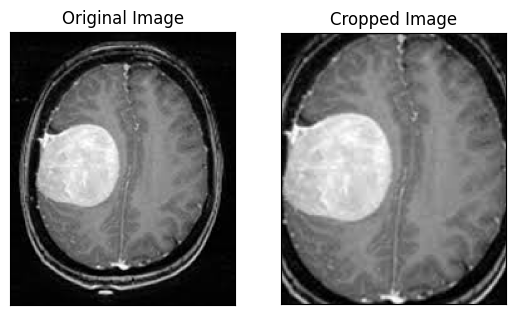

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)


In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

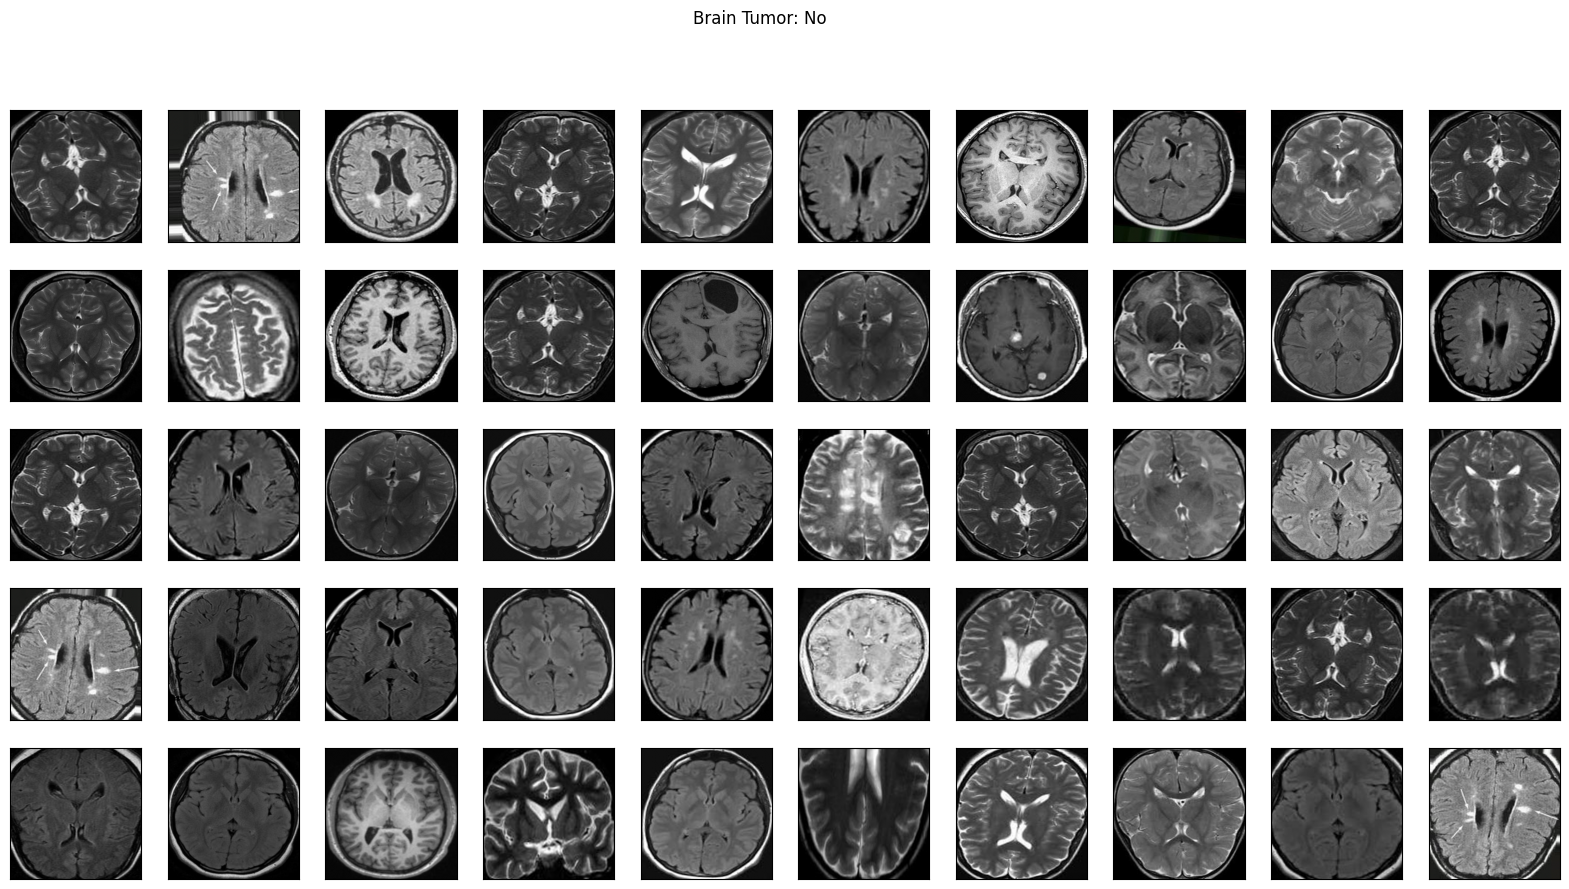

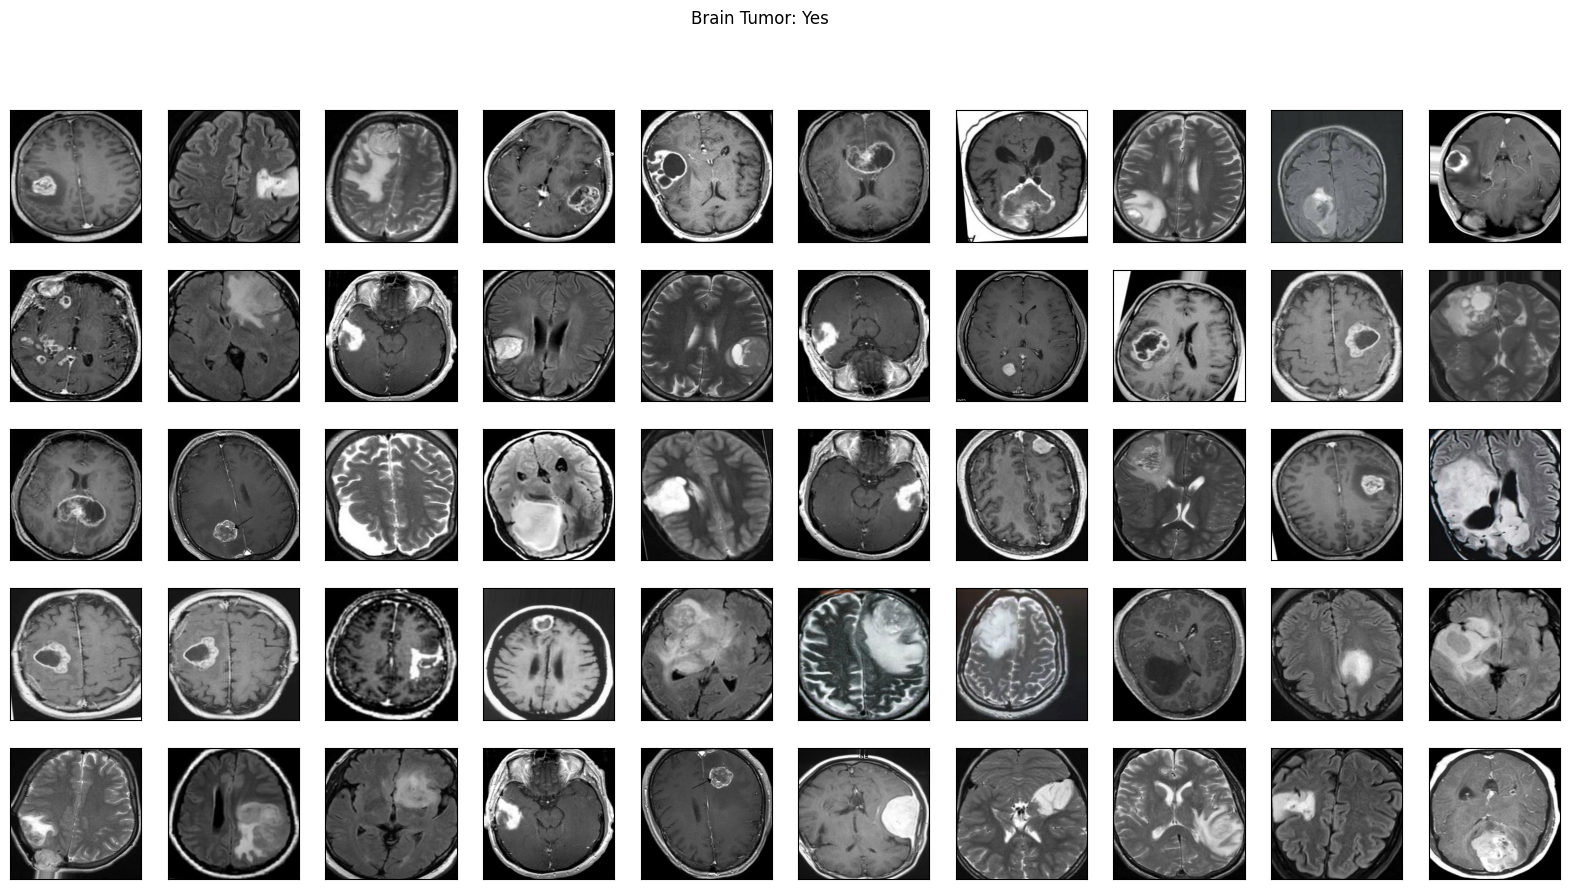

In [7]:
plot_sample_images(X, y)

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

Resnet-50 model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the trained model
#model.save('Model/resnet50_brain_tumor_detection.h5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_pad           │ (None, 246, 246,  │       0 │ input_layer[0][0]    │
│ (ZeroPadding2D)     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │   9,472 │ conv1_pad[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_bn            │ (None, 120, 120,  │     256 │ conv1_conv[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_relu          │ (None, 120, 120,  │       0 │ conv1_bn[0][0]       │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pad           │ (None, 122, 122,  │       0 │ conv1_relu[0][0]     │
│ (ZeroPadding2D)     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pool          │ (None, 60, 60,    │       0 │ pool1_pad[0][0]      │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │   4,160 │ pool1_pool[0][0]     │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │     256 │ conv2_block1_1_conv… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │       0 │ conv2_block1_1_bn[0… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │  36,928 │ conv2_block1_1_relu… │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │     256 │ conv2_block1_2_conv… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │       0 │ conv2_block1_2_bn[0… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │  16,640 │ pool1_pool[0][0]     │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │  16,640 │ conv2_block1_2_relu… │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │   1,024 │ conv2_block1_0_conv… │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │   1,024 │ conv2_block1_3_conv

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4980 - loss: 0.7551 - val_accuracy: 0.4581 - val_loss: 0.7381
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5500 - loss: 0.6883 - val_accuracy: 0.5935 - val_loss: 0.6452
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5856 - loss: 0.7072 - val_accuracy: 0.6452 - val_loss: 0.6280
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5907 - loss: 0.6594 - val_accuracy: 0.4806 - val_loss: 0.7340
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5899 - loss: 0.6634 - val_accuracy: 0.6065 - val_loss: 0.6212
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5978 - loss: 0.6475 - val_accuracy: 0.5129 - val_loss: 0.7036
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6124 - loss: 0.6341 - val_accuracy: 0.6710 - val_loss: 0.6025
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6497 - loss: 0.6176 - val_accuracy: 0.6871 - val_los

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6496 - loss: 0.6422 - val_accuracy: 0.6903 - val_loss: 0.5851
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7011 - loss: 0.5631 - val_accuracy: 0.5742 - val_loss: 0.6881
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6427 - loss: 0.6480 - val_accuracy: 0.6419 - val_loss: 0.5861
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6504 - loss: 0.6053 - val_accuracy: 0.7258 - val_loss: 0.5756
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7000 - loss: 0.5708 - val_accuracy: 0.7000 - val_loss: 0.5586
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7094 - loss: 0.5509 - val_accuracy: 0.6161 - val_loss: 0.6054
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6676 - loss: 0.5937 - val_accuracy: 0.6484 - val_loss: 0.6095
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6536 - loss: 0.6061 - val_accuracy: 0.7226 - val_

In [15]:
loss, acc = model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6419 - loss: 0.5869


In [16]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>